In [130]:
import numpy as np
import json
import math
import glob
import os
import google.protobuf
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
import Data_pb2
from Utils import distance,offset_coord,gps_fromxy,gps2local,get_file_list,load_data_packs,location_interpolate
from Utils import parse_path_packages,parse_point_packages
import pandas as pd

# Data processing

In [147]:
with open('metadata_ap.json') as f:
    metadata_ap = json.load(f)

In [148]:
aps_list = list(i for i in metadata_ap['Aps'].keys())

In [149]:
aps_list

['40:9b:cd:9d:2f:f0',
 '50:c7:bf:ff:5f:1b',
 'fc:b4:e6:2e:bb:f6',
 '84:1b:5e:49:28:9a']

In [163]:
directory = "/Users/lawrence/Desktop/MEng_2020/IPS/FpData/unlabeled"
result = pd.DataFrame({'bssid' : [],'level':[]})
final_result = []
for filename in os.listdir(directory):
    if filename.endswith(".pbf"):
        fin = open(os.path.join(directory, filename),'rb')
        datapack = Data_pb2.DataPack()
        datapack.ParseFromString(fin.read())
        fin.close()
        result = pd.DataFrame({'bssid' : [],'level':[]})
        for i in datapack.rssItems:
            if i.bssid in aps_list:
                result = result.append({'bssid': i.bssid,'level':i.level}, ignore_index=True)
        try:
            temp = result.groupby('bssid').mean()['level'].to_numpy()
        except:
            pass
        final_result = np.append(final_result,temp,axis=0)
unlabeled_data = final_result.reshape((int(len(final_result)/4),4))

In [153]:
pd.DataFrame(unlabeled_data).to_csv("unlabeled_itb.csv",header=None,index=None)

In [162]:
unlabeled_data

array([[-57.33333333, -53.66666667, -63.33333333, -54.33333333],
       [-64.66666667, -74.5       , -83.33333333, -79.        ],
       [-70.5       , -69.5       , -78.        , -63.        ],
       [-53.        , -54.66666667, -59.66666667, -61.        ],
       [-74.66666667, -78.33333333, -72.66666667, -82.33333333],
       [-53.        , -54.66666667, -59.66666667, -61.        ],
       [-61.33333333, -68.66666667, -75.5       , -83.5       ],
       [-64.5       , -71.        , -83.        , -78.        ],
       [-67.        , -74.        , -83.        , -85.5       ],
       [-57.33333333, -53.66666667, -63.33333333, -54.33333333],
       [-74.66666667, -78.33333333, -72.66666667, -82.33333333]])

In [164]:
unlabeled_data.shape

(11, 4)

# Label Propagation

In [154]:
import DG_SSL.dg_ssl as dg_ssl
import importlib
import pandas as pd
importlib.reload(dg_ssl)

<module 'DG_SSL.dg_ssl' from '/Users/lawrence/Desktop/MEng_Jianpeng/DG_SSL/dg_ssl.py'>

In [155]:
training_data = pd.read_csv("training_data_itb.csv",header=None).to_numpy()

In [156]:
unlabeled = np.append(unlabeled_data,np.zeros((unlabeled_data.shape[0],2)),axis=1)

In [165]:
propagation_results = dg_ssl.dg_ssl_init(training_data,unlabeled)[1]

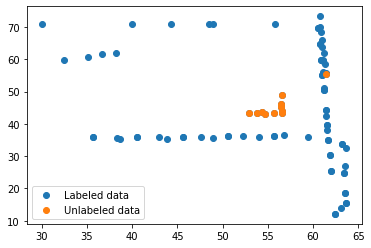

In [166]:
plt.scatter(propagation_results[:,-2],propagation_results[:,-1],label='Labeled data')
plt.scatter(propagation_results[:,-2][-11:],propagation_results[:,-1][-11:],label='Unlabeled data')
plt.legend()

In [159]:
pd.DataFrame(propagation_results,index=None,columns=None).to_csv("propagation_itb.csv")

# Downstream Model Training 

In [167]:
import importlib
import gps_deployment.gps_starting as gps
import gps_deployment.main_controller as gps1
import gps_deployment.gaussian as gps2
importlib.reload(gps)
importlib.reload(gps1)
importlib.reload(gps2)

<module 'gps_deployment.gaussian' from '/Users/lawrence/Desktop/MEng_Jianpeng/gps_deployment/gaussian.py'>

Training gaussian models to find best parameters ..
Optimal hyperparameters:[11.0, 1.0, 0.5]data fit term 10.812199540271875Likelihood-39.40782097953012
None
Training gaussian models to find best parameters ..
Optimal hyperparameters:[12.0, 2.0, 1.0]data fit term 12.222676966015426Likelihood-64.79918039587706
None
Training gaussian models to find best parameters ..
Optimal hyperparameters:[13.0, 3.0, 1.5]data fit term 8.390265828537363Likelihood-74.80604613454905
None
Training gaussian models to find best parameters ..
Optimal hyperparameters:[14.0, 4.0, 2.0]data fit term 8.59163078290763Likelihood-84.7233115016806
None


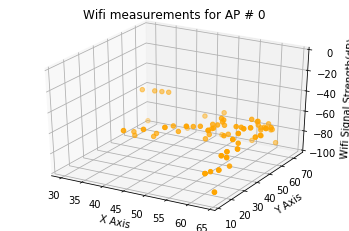

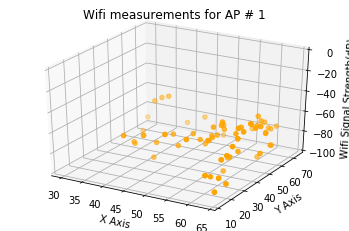

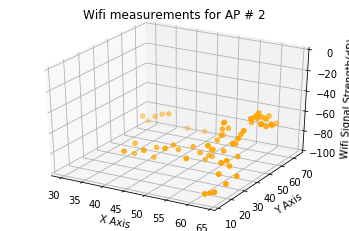

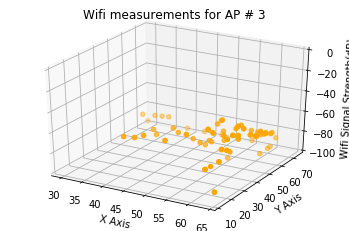

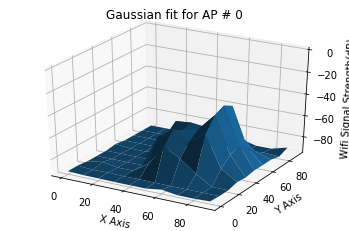

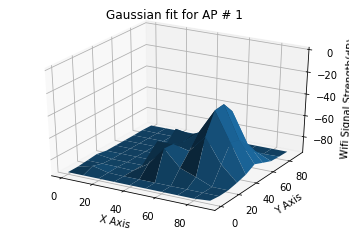

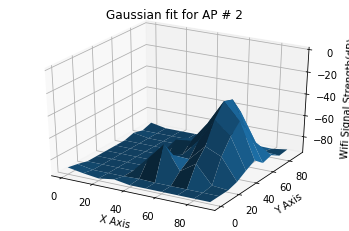

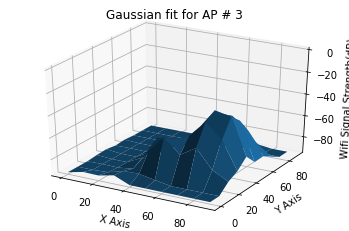

In [161]:
gps_results = gps.gps_start(4,propagation_results)

In [127]:
test_point = [-70, -93 , -73, -80]
GPs_estimation = gps.estimate(gps_results,4,test_point)

In [168]:
GPs_estimation

{'location': [34, 28]}